In [2]:
# dataset
FILENAME = "compounds_ms2structures"

# similarity calculation
MORGAN_RADIUS=9
FINGERPRINT_BITS=4096

# analogue selection
NUM_QUERIES = 1000
GROUP_SIZE=10
SIMILARITY_RANGE=(0.7, 0.9999)
NO_OVERLAP=False
RANDOM_SELECT = True   # Set to false to iterate through the dataset sequentially. Might be be better for high similarity selections.
SEED=42

# unsimilar query selection
MAX_SIMILARITY = 0.15

## Init

In [3]:
import os
import random
import pandas as pd
import numpy as np
import numba
from numba import prange
from tqdm.notebook import tqdm

from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFingerprintGenerator, SmilesMolSupplier

from fingerprint_computation import FingerprintGenerator, compute_fingerprints_from_smiles
from ms_chemical_space_explorer.similarity_maps import generate_mol, get_similarity_map_weights, FingerprintFunction

path = os.path.join( "data", "datasets", FILENAME + ".csv")
fingerprints_file = os.path.join("data", "group_similarity", f"{FILENAME}_fingerprints_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
sim_matrix_file = os.path.join("data", "group_similarity", f"{FILENAME}_ruzicka_similarities_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
df_file = os.path.join("data", "group_similarity", "benchmarks", "backup", f"{FILENAME}_benchmark_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{GROUP_SIZE}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")

if FILENAME == "compounds_ms2structures":
    mol_supplier = SmilesMolSupplier(path, delimiter=',', titleLine=True, smilesColumn=1, nameColumn=0)
elif FILENAME == "biostructures_combined":
    mol_supplier = SmilesMolSupplier(path, titleLine=True, nameColumn=0)

compounds = pd.read_csv(path)
compounds.head()

inchikey                                             smiles  \
0  AAAQFGUYHFJNHI  CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...   
1  AABFWJDLCCDJJN   COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54   
2  AABILZKQMVKFHP  C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...   
3  AABUHSBGEIUSRJ           CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2   
4  AABUKWVVUWBZCS  C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...   

         mass                        cf_class           cf_subclass  \
0  423.146204                 Benzodiazepines   1,4-benzodiazepines   
1  324.126264               Harmala alkaloids                   NaN   
2  427.220624                             NaN                   NaN   
3  280.120724  Cinnamic acids and derivatives  Cinnamic acid amides   
4  314.094724                   Neoflavonoids           Neoflavones   

                      cf_superclass       formula        npc_class_results  \
0      Organoheterocyclic compounds  C22H22ClN5O2                      NaN   
1         Alkaloids and derivatives     C22H16N2O      Carboline alkaloids   
2         Alkaloids and derivatives     C21H33NO8  Pyrrolizidine alkaloids   
3  Phenylpropanoids and polyketides    C17H16N2O2     Cinnamic acid amides   
4  Phenylpropanoids and polyketides      C21H14O3            Neoflavonoids   

               npc_pathway_results    npc_superclass_results  
0                        Alkaloids                       NaN  
1                        Alkaloids      Tryptophan alkaloids  
2                        Alkaloids       Ornithine alkaloids  
3  Shikimates and Phenylpropanoids  Phenylpropanoids (C6-C3)  
4  Shikimates and Phenylpropanoids                Flavonoids

In [4]:
compounds.smiles[12]

'CCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](COP(=O)([O-])OCC[N+](C)(C)C)[C@@H](/C=C/CCCCCCCCCCCCC)O'

## Fingerprints & Similarities

In [5]:
# code taken from https://github.com/florian-huber/molecular_fingerprint_comparisons
@numba.njit
def ruzicka_similarity(A, B):
    """
    Calculate the Ruzicka similarity between two count vectors.
    
    Parameters:
    A (array-like): First count vector.
    B (array-like): Second count vector.
    
    Returns:
    float: Ruzicka similarity.
    """
    
    min_sum = np.sum(np.minimum(A, B))
    max_sum = np.sum(np.maximum(A, B))
    
    return min_sum / max_sum


@numba.jit(nopython=True, fastmath=True, parallel=True)
def ruzicka_similarity_matrix(references: np.ndarray, queries: np.ndarray) -> np.ndarray:
    """Returns matrix of Ruzicka similarity between all-vs-all vectors of references and queries.

    Parameters
    ----------
    references
        Reference vectors as 2D numpy array. Expects that vector_i corresponds to
        references[i, :].
    queries
        Query vectors as 2D numpy array. Expects that vector_i corresponds to
        queries[i, :].

    Returns
    -------
    scores
        Matrix of all-vs-all similarity scores. scores[i, j] will contain the score
        between the vectors references[i, :] and queries[j, :].
    """
    assert references.shape[1] == queries.shape[1], "Vector sizes do not match!"

    size1 = references.shape[0]
    size2 = queries.shape[0]
    scores = np.zeros((size1, size2)) #, dtype=np.float32)
    for i in prange(size1):
        for j in range(size2):
            scores[i, j] = ruzicka_similarity(references[i, :], queries[j, :])
    return scores


def compute_similarity_matrix(fingerprints, sim_matrix_file):
    similarities_morgan_count = ruzicka_similarity_matrix(fingerprints, fingerprints)
    np.save(sim_matrix_file, similarities_morgan_count.astype(np.float32)) # big one ~5GB
    return np.load(sim_matrix_file, mmap_mode ='r')

In [6]:
fingerprints = np.load(fingerprints_file, mmap_mode ='r')
sim_matrix = np.load(sim_matrix_file, mmap_mode ='r')

print(fingerprints.shape, sim_matrix.shape)

(37811, 4096) (37811, 37811)


## Load benchmark with similar groups

In [7]:
def str_to_list_of_ints(series):
    return [int(x) for x in series.strip("[]").split(",") if x.strip().isdigit()]


analogue_df = pd.read_csv(df_file, index_col=0)
analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
print(f"Found {df_file}\nLoaded {len(analogue_df)} analogue groups.")
analogue_df

Found data\group_similarity\benchmarks\backup\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Loaded 1000 analogue groups.


analogue_ids  query_sim  \
query_id                                                                 
35713     [23200, 15235, 23492, 16509, 788, 36440, 6612,...   0.757227   
6698      [4956, 18407, 36935, 14442, 34068, 12344, 9297...   0.728808   
23723     [6469, 4900, 21458, 21338, 4110, 2985, 4580, 3...   0.776946   
23219     [34068, 19889, 23098, 30328, 4192, 27915, 4203...   0.764761   
7161      [6420, 34482, 15048, 9393, 8816, 6018, 14039, ...   0.752489   
...                                                     ...        ...   
9389      [13371, 16668, 1846, 4964, 12, 26636, 25711, 3...   0.856211   
34088     [16501, 19951, 7447, 20032, 33526, 11214, 2076...   0.793224   
26225     [8055, 31010, 7549, 29135, 276, 7567, 27413, 3...   0.754275   
5560      [22951, 13939, 37510, 32822, 14718, 7274, 2215...   0.804898   
26268     [7341, 31715, 8091, 18091, 4263, 32575, 5562, ...   0.778879   

          group_sim       sgs  sgs_score  query_id_unsimilar  \
query_id                                                       
35713      0.651649  0.718469   0.958369              7296.0   
6698       0.741461  0.711796   0.930022              1639.0   
23723      0.714194  0.768828   0.958988             18024.0   
23219      0.679330  0.671523   0.952904             16049.0   
7161       0.651582  0.704055   0.949291             14628.0   
...             ...       ...        ...                 ...   
9389       0.793353  0.725266   0.981181             29804.0   
34088      0.726373  0.781378   0.950357             24155.0   
26225      0.703045  0.700822   0.937447             17181.0   
5560       0.719795  0.793494   0.968366             24970.0   
26268      0.742973  0.742873   0.964622             24344.0   

          query_sim_unsimilar  sgs_score_unsimilar  query_mean_weights  
query_id                                                                
35713                0.048941             0.495740            0.745032  
6698                 0.034004             0.529015            0.699278  
23723                0.019481             0.433941            0.779438  
23219                0.046053             0.593117            0.690729  
7161                 0.032426             0.504996            0.736315  
...                       ...                  ...                 ...  
9389                 0.012239             0.555282            0.724871  
34088                0.017810             0.413372            0.760490  
26225                0.028164             0.524335            0.721508  
5560                 0.043849             0.422505            0.802863  
26268                0.021773             0.451774            0.714118  

[1000 rows x 9 columns]

## Benchmark

In [8]:
def pick_unsimilar_query(group_ids, sim_matrix, max_similarity_threshold):
    sims =[]
    used_queries = []
    
    query_id = random.randint(0, len(sim_matrix) - 1)
    found_unsimilar_query = False
    while found_unsimilar_query == False:
        # pick unused query
        while query_id in used_queries:
            query_id = random.randint(0, len(sim_matrix) - 1)
        used_queries.append(query_id)
        
        # get similarities to group
        sims = []
        for group_id in group_ids:
            sims.append(sim_matrix[query_id, group_id])
        
        # check if query is unsimilar enough
        if np.max(sims) < max_similarity_threshold:
            break
    
    return query_id, sims

In [9]:
def off_diagonal_mean(matrix):
    n = matrix.shape[0]
    # Create mask for off-diagonal elements
    mask = ~np.eye(n, dtype=bool)
    return matrix[mask].mean()


def get_group_sized_benchmark_df_file(df_file, analogue_df, sim_matrix, mol_supplier, morgan_radius, fpSize, group_size):
    try:
        load_df = pd.read_csv(df_file, index_col=0)
        load_df["analogue_ids"] = load_df["analogue_ids"].apply(str_to_list_of_ints)
        print(f"Found {df_file}\nTrying to access benchmark columns.\nExisting columns: {load_df.columns.tolist()}")
        query_sim_unsimilar = load_df[:1].query_sim_unsimilar
        mqw_unsimilar = load_df[:1].mqw_unsimilar
        sqs_unsimilar=load_df[:1].sqs_unsimilar
        analogue_df = load_df
        print(f"Benchmark found! Loaded benchmark for {len(load_df)} queries.")
    except Exception as e:
        print(f"Benchmark not found: {df_file}\nRunning the benchmark dataframe generation.")
        # generate benchmark dataframe
        fp_function = FingerprintFunction(fingerprint="MORGAN")
        fp_function.fp_type = "count"
        fp_function.morgan_radius = morgan_radius
        fp_function.nbits = fpSize

        for query_id, row in tqdm(analogue_df.iterrows(), desc="Processing queries", total=len(analogue_df)):
            analogue_ids = [int(x) for x in row["analogue_ids"]][:group_size]
            # query_id_unsimilar, query_sims_unsimilar = pick_unsimilar_query(analogue_ids, sim_matrix, max_similarity_threshold)
            query_id_unsimilar = int(analogue_df.loc[query_id, 'query_id_unsimilar'])
            query = mol_supplier[query_id_unsimilar]
            
            query_sims = []
            query_mean_weights = []
            query_scaled_inverted_differnces = []
            for ref_id in analogue_ids:
                # gather ruzicka similarity of analogue vs query
                query_sims.append(sim_matrix[query_id_unsimilar][ref_id])
                # generate the reference molecule
                ref_analogue = mol_supplier[ref_id]
                
                # create array for stacked weights
                stacked_atomic_weights = [0] * ref_analogue.GetNumAtoms()
                
                # compute the group similarity map weights
                for probe_id in analogue_ids:#tqdm(analogue_ids, desc=f"Computing weights for weights for analogue {ref_id}", leave=False):
                    if ref_id == probe_id:
                        continue
                    
                    probe_analogue = mol_supplier[probe_id]

                    # extract and standardize similarity weights for the reference molecule
                    ref_sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(probe_analogue, ref_analogue, fp_function.get_function, metric=DataStructs.TanimotoSimilarity) #this is the bottle neck
                    #print(f"Getting weights took {(pd.Timestamp.now() - getting_weights_start).total_seconds():.4f} seconds")

                    # stack the weights
                    stacked_atomic_weights = [stacked_atomic_weights[i] + ref_sim_weights[i] for i in range(ref_analogue.GetNumAtoms())]
                # Standardize the stacked weights
                stacked_atomic_weights, _ = SimilarityMaps.GetStandardizedWeights(stacked_atomic_weights)
                # stacked_mean_weights.append(sum(stacked_atomic_weights) / len(stacked_atomic_weights))
                
                # compute the similarity map weights against the query molecule
                query_atomic_weights = get_similarity_map_weights(ref_analogue, query, fp_function)
                query_mean_weights.append(sum(query_atomic_weights) / len(query_atomic_weights))
                
                # calculate absolute weight difference for each atom against the query
                query_abs_differences = ([abs(stacked_atomic_weights[i] - query_atomic_weights[i]) for i in range(len(stacked_atomic_weights))])
                query_mean_difference = sum(query_abs_differences) / len(query_abs_differences)
                
                # scale and invert the mean absolute difference to get a similarity score
                query_scaled_inverted_differnce = 1 - (query_mean_difference * 0.5)
                query_scaled_inverted_differnces.append(query_scaled_inverted_differnce)
            # --- gather all similarity metrics ---
            # mean ruzicka similarity of analogue vs query ruzicka similaities
            analogue_df.loc[query_id, "query_sim_unsimilar"] = np.mean(query_sims)
            
            #  mean of the means of query atomic weights
            unscaled_query_mean_weights = np.mean(query_mean_weights)  # range [-1, 1]
            analogue_df.loc[query_id, "mqw_unsimilar"] = (unscaled_query_mean_weights + 1) / 2   # range [0, 1]
            
            # # mean of all-vs-all analogue ruzicka similarities
            # fp_group_sim_matrix = ruzicka_similarity_matrix(fingerprints[analogue_ids], fingerprints[analogue_ids])
            # group_sim = off_diagonal_mean(fp_group_sim_matrix)
            # analogue_df.loc[query_id, "group_sim"] = group_sim
            
            # # mean of the means of stacked atomic weights of all-vs-all analogue similarity maps
            # unscaled_sgs = np.mean(stacked_mean_weights)                # range [-1, 1]
            # analogue_df.loc[query_id, "sgs"] = (unscaled_sgs + 1) / 2   # range [0, 1]
            
            # scaled and inverted mean of the means of the absolute differences between atomic stacked weights and atomic query weights
            sgs_score = (sum(query_scaled_inverted_differnces) / len(query_scaled_inverted_differnces))
            analogue_df.loc[query_id, "sqs_unsimilar"] = sgs_score

        analogue_df.to_csv(df_file)
        print(f"Saved {len(analogue_df)} queries to {df_file}.")
    return analogue_df

In [10]:
max_group_size = GROUP_SIZE + 1
all_dfs = []
big_df = pd.read_csv(df_file, index_col=0)#get_analogue_groups_df(df_file, NUM_QUERIES, RANDOM_SELECT, GROUP_SIZE, SIMILARITY_RANGE, NO_OVERLAP, SEED, MORGAN_RADIUS, FINGERPRINT_BITS)
big_df["analogue_ids"] = big_df["analogue_ids"].apply(str_to_list_of_ints)

for group_size in tqdm(range(2, max_group_size), desc="Benchmarking varying group sizes..."):
    group_sized_df_file = os.path.join("data", "group_similarity", "benchmarks", f"{FILENAME}_dissimilarity_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{group_size}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")
    analogue_df = get_group_sized_benchmark_df_file(group_sized_df_file, big_df, sim_matrix, mol_supplier, MORGAN_RADIUS, FINGERPRINT_BITS, group_size)
    # analogue_df["group_sim_diff"] = abs(analogue_df.sgs - analogue_df.group_sim)
    # print(f"-------- Group size {group_size}: Entries with group_sim_diff greater than 0.05 = {len(analogue_df[analogue_df.group_sim_diff > 0.05])} --------")
    all_dfs.append(analogue_df)

Benchmarking varying group sizes...:   0%|          | 0/9 [00:00<?, ?it/s]

Found data\group_similarity\benchmarks\compounds_ms2structures_dissimilarity_num_queries1000_random1_size2_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Trying to access benchmark columns.
Existing columns: ['analogue_ids', 'query_sim', 'group_sim', 'sgs', 'sgs_score', 'query_id_unsimilar', 'query_sim_unsimilar', 'sgs_score_unsimilar', 'query_mean_weights', 'mqw_unsimilar', 'sqs_unsimilar']
Benchmark found! Loaded benchmark for 1000 queries.
Found data\group_similarity\benchmarks\compounds_ms2structures_dissimilarity_num_queries1000_random1_size3_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Trying to access benchmark columns.
Existing columns: ['analogue_ids', 'query_sim', 'group_sim', 'sgs', 'sgs_score', 'query_id_unsimilar', 'query_sim_unsimilar', 'sgs_score_unsimilar', 'query_mean_weights', 'mqw_unsimilar', 'sqs_unsimilar']
Benchmark found! Loaded benchmark for 1000 queries.
Found data\group_similarity\benchmarks\compounds_ms2structures_dissimilarity_num_q

xmin = min(analogue_df.sgs.min(), analogue_df.group_sim.min())
xmax = max(analogue_df.sgs.max(), analogue_df.group_sim.max())

In [11]:
all_dfs[0].columns

Index(['analogue_ids', 'query_sim', 'group_sim', 'sgs', 'sgs_score',
       'query_id_unsimilar', 'query_sim_unsimilar', 'sgs_score_unsimilar',
       'query_mean_weights', 'mqw_unsimilar', 'sqs_unsimilar'],
      dtype='object')

In [12]:
# Check if differences are within floating point tolerance
import numpy as np

for i, df in enumerate(all_dfs):
    if i == 0:
        continue
    for column in df.columns:
        if not all_dfs[0][column].equals(df[column]):
            diff = abs(all_dfs[0][column].mean() - df[column].mean())
            is_fp_error = np.allclose([all_dfs[0][column].values], [df[column].values])
            print(f"DIFFERENT in df0 and df{i}: {column}")
            print(f"  Difference: {diff:.2e}")
            print(f"  Within FP tolerance: {is_fp_error}")
            print()

DIFFERENT in df0 and df1: query_sim_unsimilar
  Difference: 1.12e-05
  Within FP tolerance: False

DIFFERENT in df0 and df1: mqw_unsimilar
  Difference: 5.67e-05
  Within FP tolerance: False

DIFFERENT in df0 and df1: sqs_unsimilar
  Difference: 5.43e-03
  Within FP tolerance: False

DIFFERENT in df0 and df2: query_sim_unsimilar
  Difference: 3.24e-06
  Within FP tolerance: False

DIFFERENT in df0 and df2: mqw_unsimilar
  Difference: 1.72e-05
  Within FP tolerance: False

DIFFERENT in df0 and df2: sqs_unsimilar
  Difference: 6.76e-03
  Within FP tolerance: False

DIFFERENT in df0 and df3: query_sim_unsimilar
  Difference: 1.50e-05
  Within FP tolerance: False

DIFFERENT in df0 and df3: mqw_unsimilar
  Difference: 1.78e-04
  Within FP tolerance: False

DIFFERENT in df0 and df3: sqs_unsimilar
  Difference: 7.43e-03
  Within FP tolerance: False

DIFFERENT in df0 and df4: query_sim_unsimilar
  Difference: 1.69e-05
  Within FP tolerance: False

DIFFERENT in df0 and df4: mqw_unsimilar
  Diff

# Results

In [13]:
all_dfs[0].describe()

query_sim    group_sim          sgs    sgs_score  query_id_unsimilar  \
count  1000.000000  1000.000000  1000.000000  1000.000000         1000.000000   
mean      0.784824     0.735464     0.738398     0.957548        18985.421000   
std       0.031377     0.045664     0.031290     0.015605        10818.095266   
min       0.716962     0.623999     0.619026     0.896554           26.000000   
25%       0.761932     0.701849     0.720571     0.948777         9729.750000   
50%       0.781721     0.731256     0.735877     0.957966        18532.000000   
75%       0.803512     0.766433     0.760394     0.966872        28568.750000   
max       0.876133     0.903892     0.816185     0.996199        37787.000000   

       query_sim_unsimilar  sgs_score_unsimilar  query_mean_weights  \
count          1000.000000          1000.000000         1000.000000   
mean              0.033881             0.491314            0.745276   
std               0.022151             0.056313            0.035400   
min               0.000000             0.378090            0.613402   
25%               0.019930             0.452948            0.724587   
50%               0.029406             0.484230            0.746556   
75%               0.041093             0.519336            0.768106   
max               0.133815             0.790356            0.852296   

       mqw_unsimilar  sqs_unsimilar  
count    1000.000000    1000.000000  
mean        0.241210       0.500317  
std         0.046647       0.065566  
min         0.152152       0.318798  
25%         0.219114       0.458647  
50%         0.233569       0.495290  
75%         0.250426       0.534657  
max         0.559311       0.794032

In [14]:
all_dfs[2][[
    'query_sim_unsimilar',
    'query_mean_weights',
    'mqw_unsimilar',
    'sqs_unsimilar']].head()

query_sim_unsimilar  query_mean_weights  mqw_unsimilar  \
query_id                                                           
35713                0.048615            0.745032       0.256182   
6698                 0.033366            0.699278       0.239453   
23723                0.018048            0.779438       0.204506   
23219                0.045837            0.690729       0.262860   
7161                 0.029662            0.736315       0.215627   

          sqs_unsimilar  
query_id                 
35713          0.500124  
6698           0.536093  
23723          0.435712  
23219          0.599960  
7161           0.522324

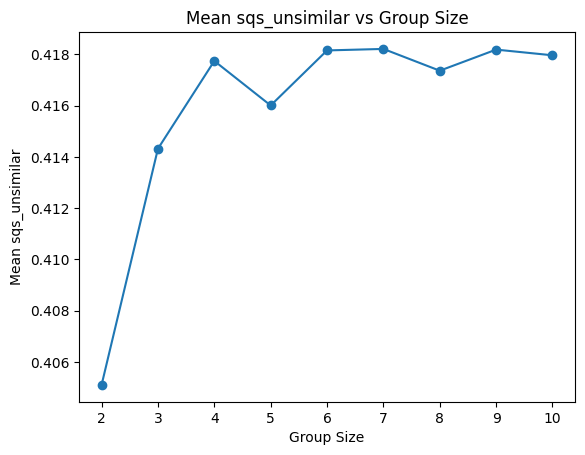

In [15]:
# plot the mean query_sim of every dataframe in all_dfs
import matplotlib.pyplot as plt

column = "sqs_unsimilar"
means = [df[column].quantile(0.05) for df in all_dfs]
plt.plot(range(2, 11), means, marker='o')
# --- IGNORE ---
plt.xlabel("Group Size")
plt.ylabel("Mean " + column)
plt.title("Mean " + column + " vs Group Size")
plt.show()


In [16]:
all_dfs[4][column].quantile(0.05)

0.41815820384255725

In [17]:
columns = all_dfs[4].columns.tolist()
columns

['analogue_ids',
 'query_sim',
 'group_sim',
 'sgs',
 'sgs_score',
 'query_id_unsimilar',
 'query_sim_unsimilar',
 'sgs_score_unsimilar',
 'query_mean_weights',
 'mqw_unsimilar',
 'sqs_unsimilar']

In [18]:
thesis_columns = [
                #'analogue_ids',
 "Query Sim.",  #'query_sim',
 "MQW",         # 'query_mean_weights',
 #"Group Sim.",  #'group_sim',
 #"SGS",         #'sgs',
 "SQS",         #'sgs_score',
                #'group_sim_diff'
 ]

new_column_order = [
 'query_sim_unsimilar',
 'mqw_unsimilar',
 #'group_sim',
 #'sgs',
 'sqs_unsimilar',
#  'query_id_unsimilar',
#  'analogue_ids',
#  'query_sim',
#  'sgs_score', 
]

color_ids = [0,1, 4]

In [19]:
benchmark_columns = columns[1:-1]
benchmark_df = pd.DataFrame(columns=thesis_columns, index=pd.Index([], name='n'))

for i in range(all_dfs.__len__()):
    n = i + 2
    # rename the df columns to thesis compliant names
    all_dfs[i] = all_dfs[i][new_column_order].copy()
    all_dfs[i].rename(columns=dict(zip(new_column_order, thesis_columns)), inplace=True)
    benchmark_df.loc[n, thesis_columns] = all_dfs[i][thesis_columns].mean()

In [20]:
all_dfs[0]

Query Sim.       MQW       SQS
query_id                                
35713       0.047504  0.257059  0.507516
6698        0.034866  0.239395  0.486296
23723       0.018182  0.201925  0.436309
23219       0.045946  0.264923  0.623578
7161        0.029543  0.216251  0.553405
...              ...       ...       ...
9389        0.011621  0.291744  0.575750
34088       0.017126  0.297697  0.508593
26225       0.029079  0.220354  0.490139
5560        0.045457  0.236962  0.478685
26268       0.022478  0.205818  0.455228

[1000 rows x 3 columns]

In [21]:
# rename columns
benchmark_df

Query Sim.       MQW       SQS
n                                
2    0.033881   0.24121  0.500317
3     0.03387  0.241266  0.494884
4    0.033878  0.241193   0.49356
5    0.033866  0.241032  0.492889
6    0.033864  0.241079  0.492558
7    0.033859  0.241144  0.491881
8    0.033868  0.241078  0.491507
9    0.033872  0.241104  0.491549
10   0.033895  0.241111  0.491314

In [22]:
benchmark_df.infer_objects().to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n & Query Sim. & MQW & SQS \\\\\nn &  &  &  \\\\\n\\midrule\n2 & 0.033881 & 0.241210 & 0.500317 \\\\\n3 & 0.033870 & 0.241266 & 0.494884 \\\\\n4 & 0.033878 & 0.241193 & 0.493560 \\\\\n5 & 0.033866 & 0.241032 & 0.492889 \\\\\n6 & 0.033864 & 0.241079 & 0.492558 \\\\\n7 & 0.033859 & 0.241144 & 0.491881 \\\\\n8 & 0.033868 & 0.241078 & 0.491507 \\\\\n9 & 0.033872 & 0.241104 & 0.491549 \\\\\n10 & 0.033895 & 0.241111 & 0.491314 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Plots

In [23]:
import matplotlib.pyplot as plt

# colors = [
#     "#780B24",
#     "#004C5F", 
#     "#64B432",
#     "#937E00",
#     "#AD001E",
#     "#0083A1",
# ]

# colors = [
#     "#e60028",
#     "#64B432", 
#     "#00afd7",
#     "#780B24",
#     "#937E00",
#     "#004C5F",
# ]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

background = "#EEECE1"

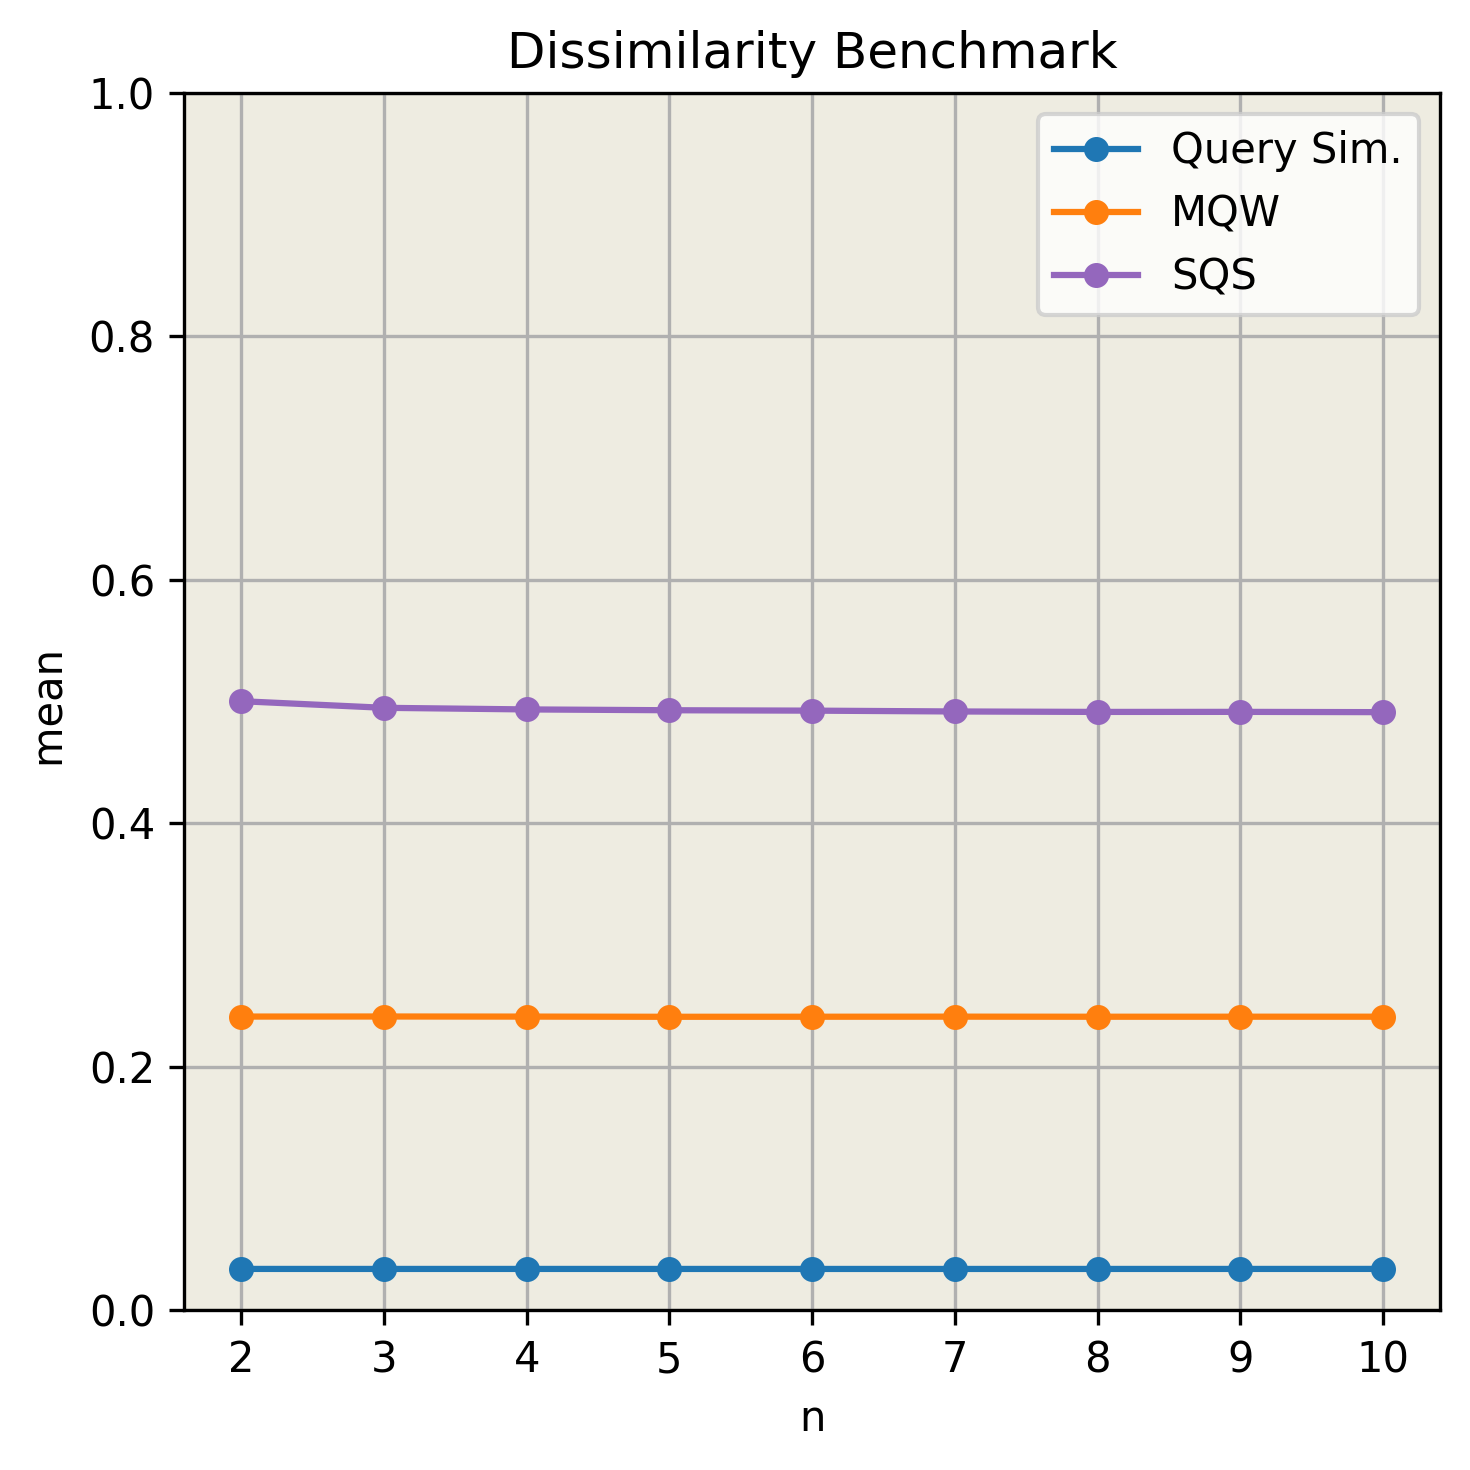

In [40]:
import matplotlib.pyplot as plt

# Create a single plot with all metrics
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

x = benchmark_df.index

# Plot all columns as separate lines on the same plot
for i, column in enumerate(thesis_columns):#[:-1]):#, start=1):
    y = benchmark_df[column]
    ax.plot(x, y, label=column, marker='o', markersize=5, color=colors[color_ids[i]])
    ax.set_facecolor(background)

ax.set_xlabel("n")
ax.set_ylabel("mean ")
ax.set_title("Dissimilarity Benchmark")
ax.grid(True)
ax.legend()
ax.set_ylim(0.0, 1)

plt.tight_layout()
plt.show()

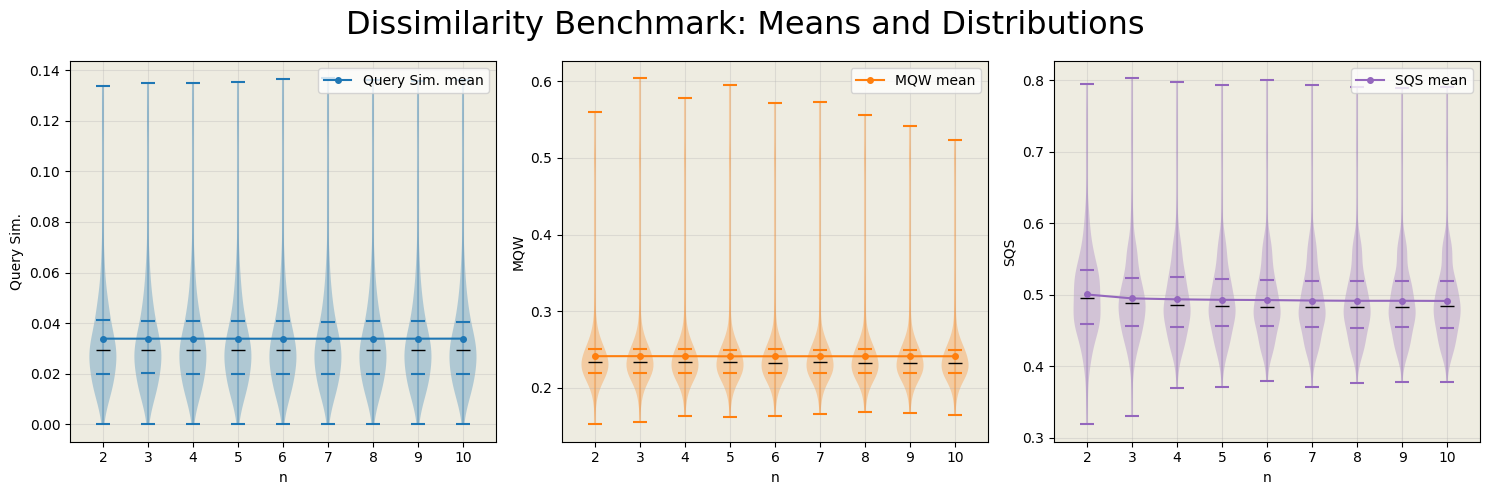

In [43]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()  # Flatten to make indexing easier

x = np.array(benchmark_df.index)  # Convert to numpy array to avoid pandas Index issues

for i, column in enumerate(thesis_columns):  # Exclude the last column
    ax = axes[i]
    y = benchmark_df[column].values  # Convert to numpy array as well
    
    # Create violin plot data for all group sizes
    violin_data = []
    for n in range(len(all_dfs)):
        violin_data.append(all_dfs[n][column].dropna().values)  # Convert to numpy array
    
    # Create violin plots
    vp = ax.violinplot(violin_data, positions=x, widths=0.6, showmeans=False, showmedians=True,
                       quantiles=[[0.25, 0.75]] * len(x))
    
    # Style the violin plots
    for pc in vp['bodies']:
        pc.set_facecolor(colors[color_ids[i]])
        pc.set_alpha(0.3)
    
    # Style the median lines
    vp['cbars'].set_color(colors[color_ids[i]])#('black')
    vp['cbars'].set_alpha(0.3)
    vp['cmins'].set_color(colors[color_ids[i]])
    vp['cmaxes'].set_color(colors[color_ids[i]])
    vp['cquantiles'].set_color(colors[color_ids[i]])
    vp['cmedians'].set_color('black')
    vp['cmedians'].set_linewidth(1)
    
    # Plot the mean line on top
    ax.plot(x, y, label=f"{column} mean", marker='o', markersize=4, 
            color=colors[color_ids[i]], linewidth=1.5, zorder=10)
    
    ax.set_facecolor(background)
    ax.set_xlabel("n")
    ax.set_ylabel(column)
    ax.grid(True, alpha=0.3)
    #ax.set_title(f"{column}")
    #ax.set_ylim(-0.05, 0.85)
    ax.legend()
    
    # Set x-axis ticks to match group sizes
    ax.set_xticks(x)
    ax.set_xticklabels(x)

# Hide the last empty subplot
#axes[5].set_visible(False)
fig.suptitle("Dissimilarity Benchmark: Means and Distributions", fontsize=23)

plt.tight_layout()
plt.show()

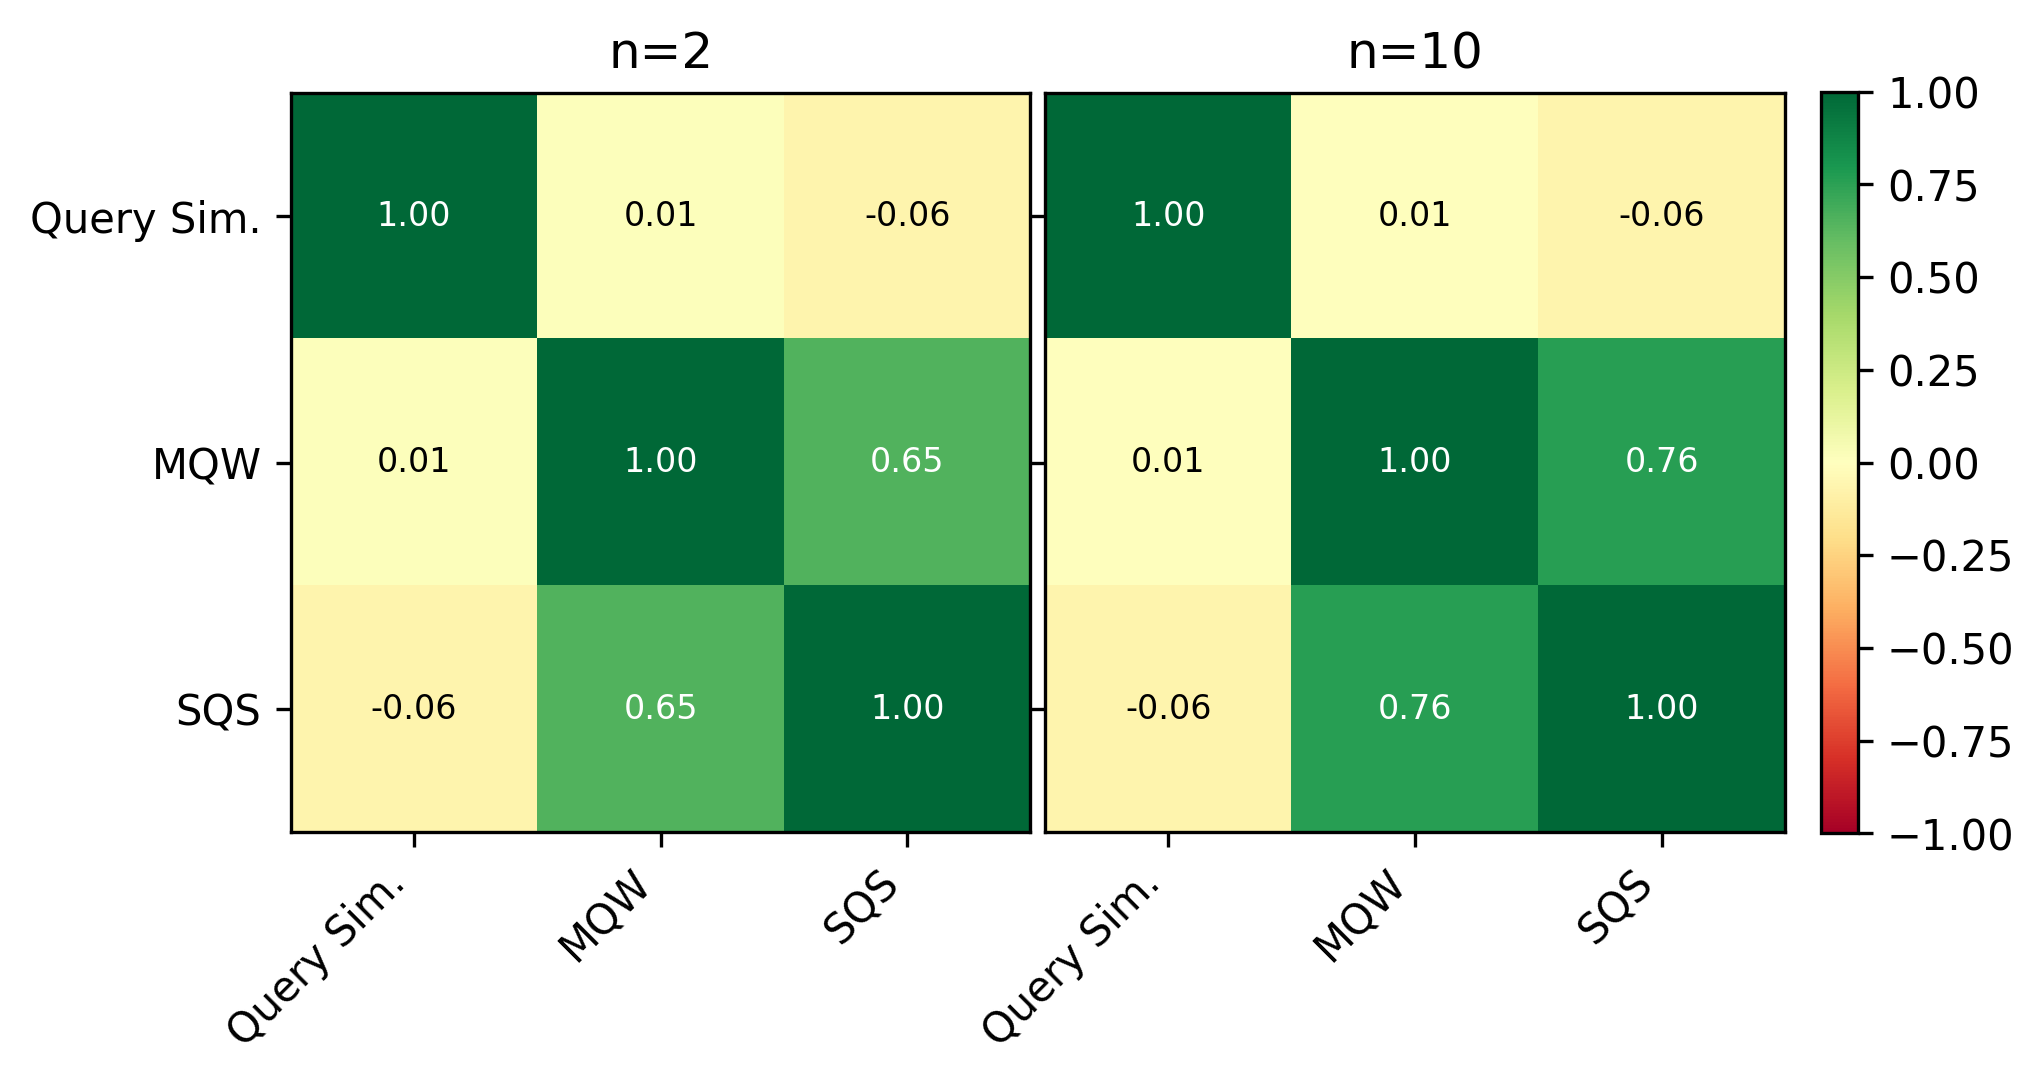

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), dpi=300)
n1 = 2
n2 = 10

# Calculate correlation matrices for both dataframes
corr_matrix_1 = all_dfs[n1-2][thesis_columns].corr()
corr_matrix_2 = all_dfs[n2-2][thesis_columns].corr()

# Create heatmaps
im1 = ax1.imshow(corr_matrix_1, cmap='RdYlGn', aspect='equal', vmin=-1, vmax=1)
im2 = ax2.imshow(corr_matrix_2, cmap='RdYlGn', aspect='equal', vmin=-1, vmax=1)

# Set ticks and labels for first subplot
ax1.set_xticks(range(len(corr_matrix_1.columns)))
ax1.set_yticks(range(len(corr_matrix_1.index)))
ax1.set_xticklabels(corr_matrix_1.columns, rotation=45, ha='right')
ax1.set_yticklabels(corr_matrix_1.index)

# Set ticks and labels for second subplot (no y-labels)
ax2.set_xticks(range(len(corr_matrix_2.columns)))
ax2.set_yticks(range(len(corr_matrix_2.index)))
ax2.set_xticklabels(corr_matrix_2.columns, rotation=45, ha='right')
ax2.set_yticklabels([])  # Remove y-labels for second plot

# Add correlation values as text for first subplot
for i in range(len(corr_matrix_1.index)):
    for j in range(len(corr_matrix_1.columns)):
        color = "white" if abs(corr_matrix_1.iloc[i, j]) > 0.5 else "black"
        ax1.text(j, i, f'{corr_matrix_1.iloc[i, j]:.2f}',
                ha="center", va="center", color=color, fontsize=8)

# Add correlation values as text for second subplot
for i in range(len(corr_matrix_2.index)):
    for j in range(len(corr_matrix_2.columns)):
        color = "white" if abs(corr_matrix_2.iloc[i, j]) > 0.5 else "black"
        ax2.text(j, i, f'{corr_matrix_2.iloc[i, j]:.2f}',
                ha="center", va="center", color=color, fontsize=8)

# Set titles
ax1.set_title(f"n={n1}")
ax2.set_title(f"n={n2}")

# Adjust subplot positions manually to reduce gap
plt.subplots_adjust(left=0.1, right=0.85, wspace=0.02)

# Add colorbar with proper sizing
cbar = fig.colorbar(im1, ax=[ax1, ax2], shrink=0.642, pad=0.02)

plt.show()

## Unused Plots

In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from pyparsing import col

# Create a figure with subplots for animation
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
axes = axes.flatten()

# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']

# Calculate global min/max for each column across all dataframes
global_x_ranges = {}
for column in thesis_columns:
    all_values = []
    for df in all_dfs:
        all_values.extend(df[column].dropna().values)
    
    if all_values:
        global_x_ranges[column] = {
            'min': min(all_values),
            'max': max(all_values)
        }
    else:
        global_x_ranges[column] = {'min': 0, 'max': 1}

# Calculate global y-axis max for histogram counts
global_y_max = 25
bins = 100
global_y_maxes = {}
for column in thesis_columns:
    column_max = 0
    for df in all_dfs:
        data = df[column].dropna()
        if len(data) > 0:
            counts, _ = np.histogram(data, bins=bins)
            column_max = max(column_max, max(counts))
    
    global_y_maxes[column] = column_max if column_max > 0 else 25

def animate(frame):
    # Clear all subplots
    for ax in axes:
        ax.clear()
    
    # Get the current dataframe
    df = all_dfs[frame]
    group_size = frame + 2
    
    # Set the main title
    fig.suptitle(f"Distribution of Similiarity Benchmark Metrics for n={group_size} Benchmark Metrics", fontsize=16)
    
    # Plot each metric
    for i, column in enumerate(thesis_columns):
        ax = axes[i]
        
        # Use consistent colors
        color = colors[color_ids[i]]
        
        # Get data and filter NaN values
        data = df[column].dropna()
        
        if len(data) > 0:
            ax.hist(data, bins=bins, alpha=0.7, label=f"{column}", color=color)
        
        # Set consistent axis limits
        ax.set_xlim(global_x_ranges[column]['min'], global_x_ranges[column]['max'])
        ax.set_ylim(0, global_y_maxes[column] * 1.05)  # Add 5% padding
        ax.set_facecolor(background)
        
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")
        ax.grid(True)
        #ax.set_title(f"{column}")
        ax.legend()
    
    plt.tight_layout()

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=len(all_dfs), interval=1000, repeat=True)
#axes[5].set_visible(False)
plt.tight_layout()

# Optionally save as GIF
#anim.save('benchmark_metrics_animation.gif', writer='pillow', fps=1.2)

# Display the animation
html = HTML(anim.to_jshtml())
plt.close(fig)  # Close the figure to avoid displaying it twice in Jupyter
html

C:\Users\kevin\AppData\Local\Temp\ipykernel_18496\127338787.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [28]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML

def update(frame):
    ax.clear()
    
    # Get current dataframe and group size
    df = all_dfs[frame]
    group_size = frame + 2  # Group sizes start at 2
    
    # Calculate correlation matrix
    corr_matrix = df[thesis_columns].corr()
    
    # Create heatmap using matplotlib
    im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', 
                    vmin=-1, vmax=1)
    
    # Set ticks and labels
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.index)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.index)
    
    # Add correlation values as text
    for i in range(len(corr_matrix.index)):
        for j in range(len(corr_matrix.columns)):
            color = "white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black"
            ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                    ha="center", va="center", color=color)#, fontsize=10)
    
    # Set title
    ax.set_title(f"Correlation Matrix for n={group_size}", fontsize=16)
    
    #plt.tight_layout()
    
    return [im]

# Create figure
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
plt.subplots_adjust(bottom=0.25, left=0.27, right=0.97)
fig.colorbar(im1, ax=ax)

# Create animation
anim = animation.FuncAnimation(fig, update, frames=len(all_dfs), interval=1000)
#plt.tight_layout()
plt.close(fig)  # Close the figure to avoid displaying it twice in Jupyter

anim.save('ssm_benchmark_all_corr.gif', writer=PillowWriter(fps=1))
HTML(anim.to_jshtml())

In [29]:
y_column = "Query Sim."
x_column = "MQW"
group_size_a = 10
group_size_b = 2
x_range = [-0.01, 0.15]
y_range = [0.1, 0.6]

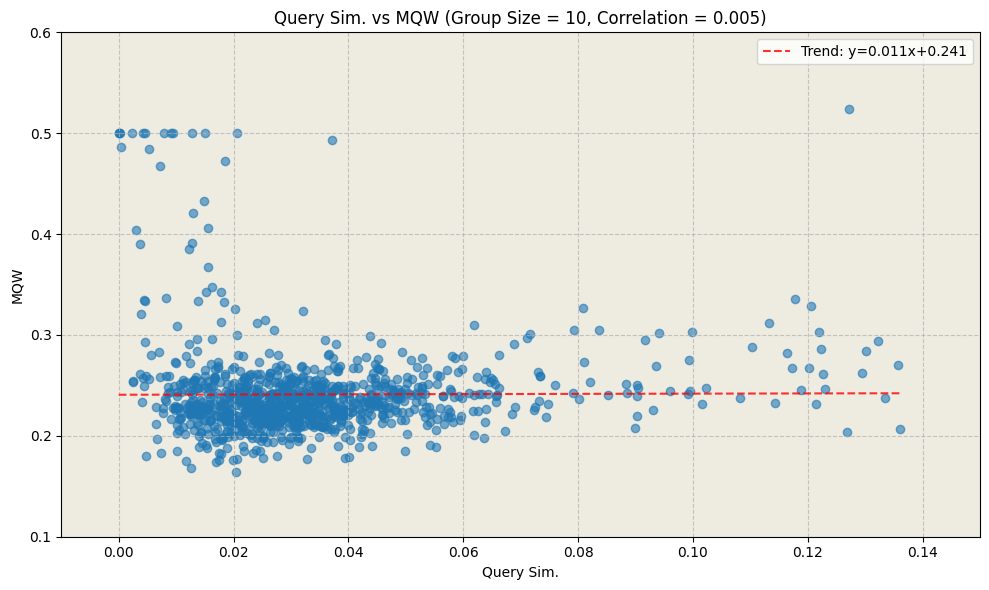

In [30]:
import numpy as np

group_size = group_size_a
# Get the first dataframe (group size = 2)
df = all_dfs[group_size - 2]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
scatter = ax.scatter(df[y_column], df[x_column], alpha=0.6)

# Add trend line
z = np.polyfit(df[y_column], df[x_column], 1)
p = np.poly1d(z)
ax.plot(df[y_column].sort_values(), p(df[y_column].sort_values()), 
    "r--", alpha=0.8, label=f"Trend: y={z[0]:.3f}x+{z[1]:.3f}")

# Calculate correlation coefficient
correlation = df[y_column].corr(df[x_column])

# Add labels and title
ax.set_facecolor(background)
ax.set_xlabel(y_column)
ax.set_ylabel(x_column)
ax.set_title(f'{y_column} vs {x_column} (Group Size = {group_size}, Correlation = {correlation:.3f})')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Set axis limits to [0, 1]
ax.set_xlim(x_range)
ax.set_ylim(y_range)

plt.tight_layout()
plt.show()

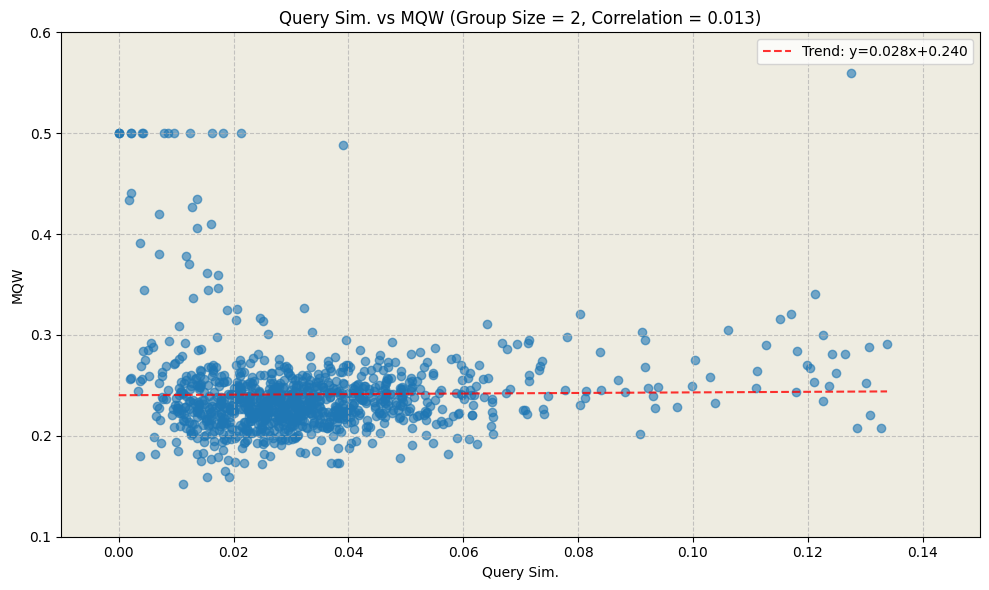

In [31]:
import numpy as np

group_size = group_size_b
# Get the first dataframe (group size = 2)
df = all_dfs[group_size - 2]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
scatter = ax.scatter(df[y_column], df[x_column], alpha=0.6)

# Add trend line
z = np.polyfit(df[y_column], df[x_column], 1)
p = np.poly1d(z)
ax.plot(df[y_column].sort_values(), p(df[y_column].sort_values()), 
    "r--", alpha=0.8, label=f"Trend: y={z[0]:.3f}x+{z[1]:.3f}")

# Calculate correlation coefficient
correlation = df[y_column].corr(df[x_column])

# Add labels and title
ax.set_facecolor(background)
ax.set_xlabel(y_column)
ax.set_ylabel(x_column)
ax.set_title(f'{y_column} vs {x_column} (Group Size = {group_size}, Correlation = {correlation:.3f})')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Set axis limits to [0, 1]
ax.set_xlim(x_range)
ax.set_ylim(y_range)

plt.tight_layout()
plt.show()

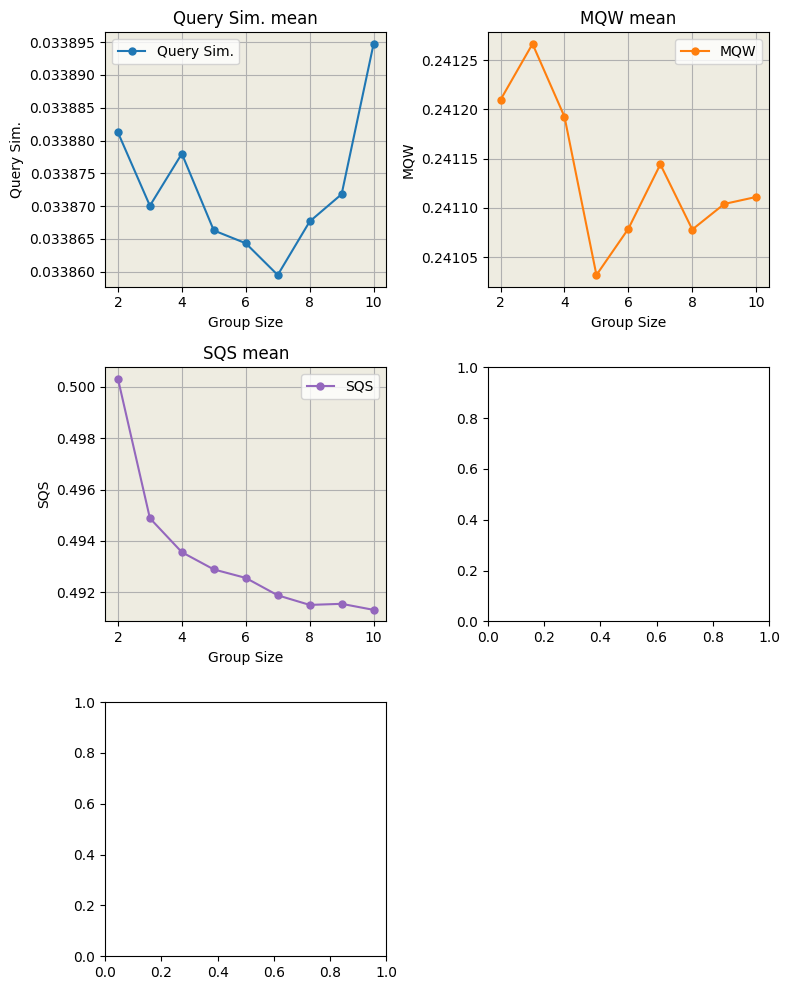

In [32]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 10))  # 2 rows, 4 columns for 7 plots + 1 empty
axes = axes.flatten()  # Flatten to make indexing easier

x = benchmark_df.index

for i, column in enumerate(thesis_columns):  # Exclude the last column
    ax = axes[i]
    y = benchmark_df[column]
    
    # Plot lines with different markers
    color = colors[i % len(colors)]
    ax.plot(x, y, label=f"{column}", marker='o', markersize=5, color=colors[color_ids[i]])
    ax.set_facecolor(background)
    
    ax.set_xlabel("Group Size")
    ax.set_ylabel(column)
    ax.grid(True)
    ax.set_title(f"{column} mean")
    ax.legend()

# Hide the last empty subplot
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

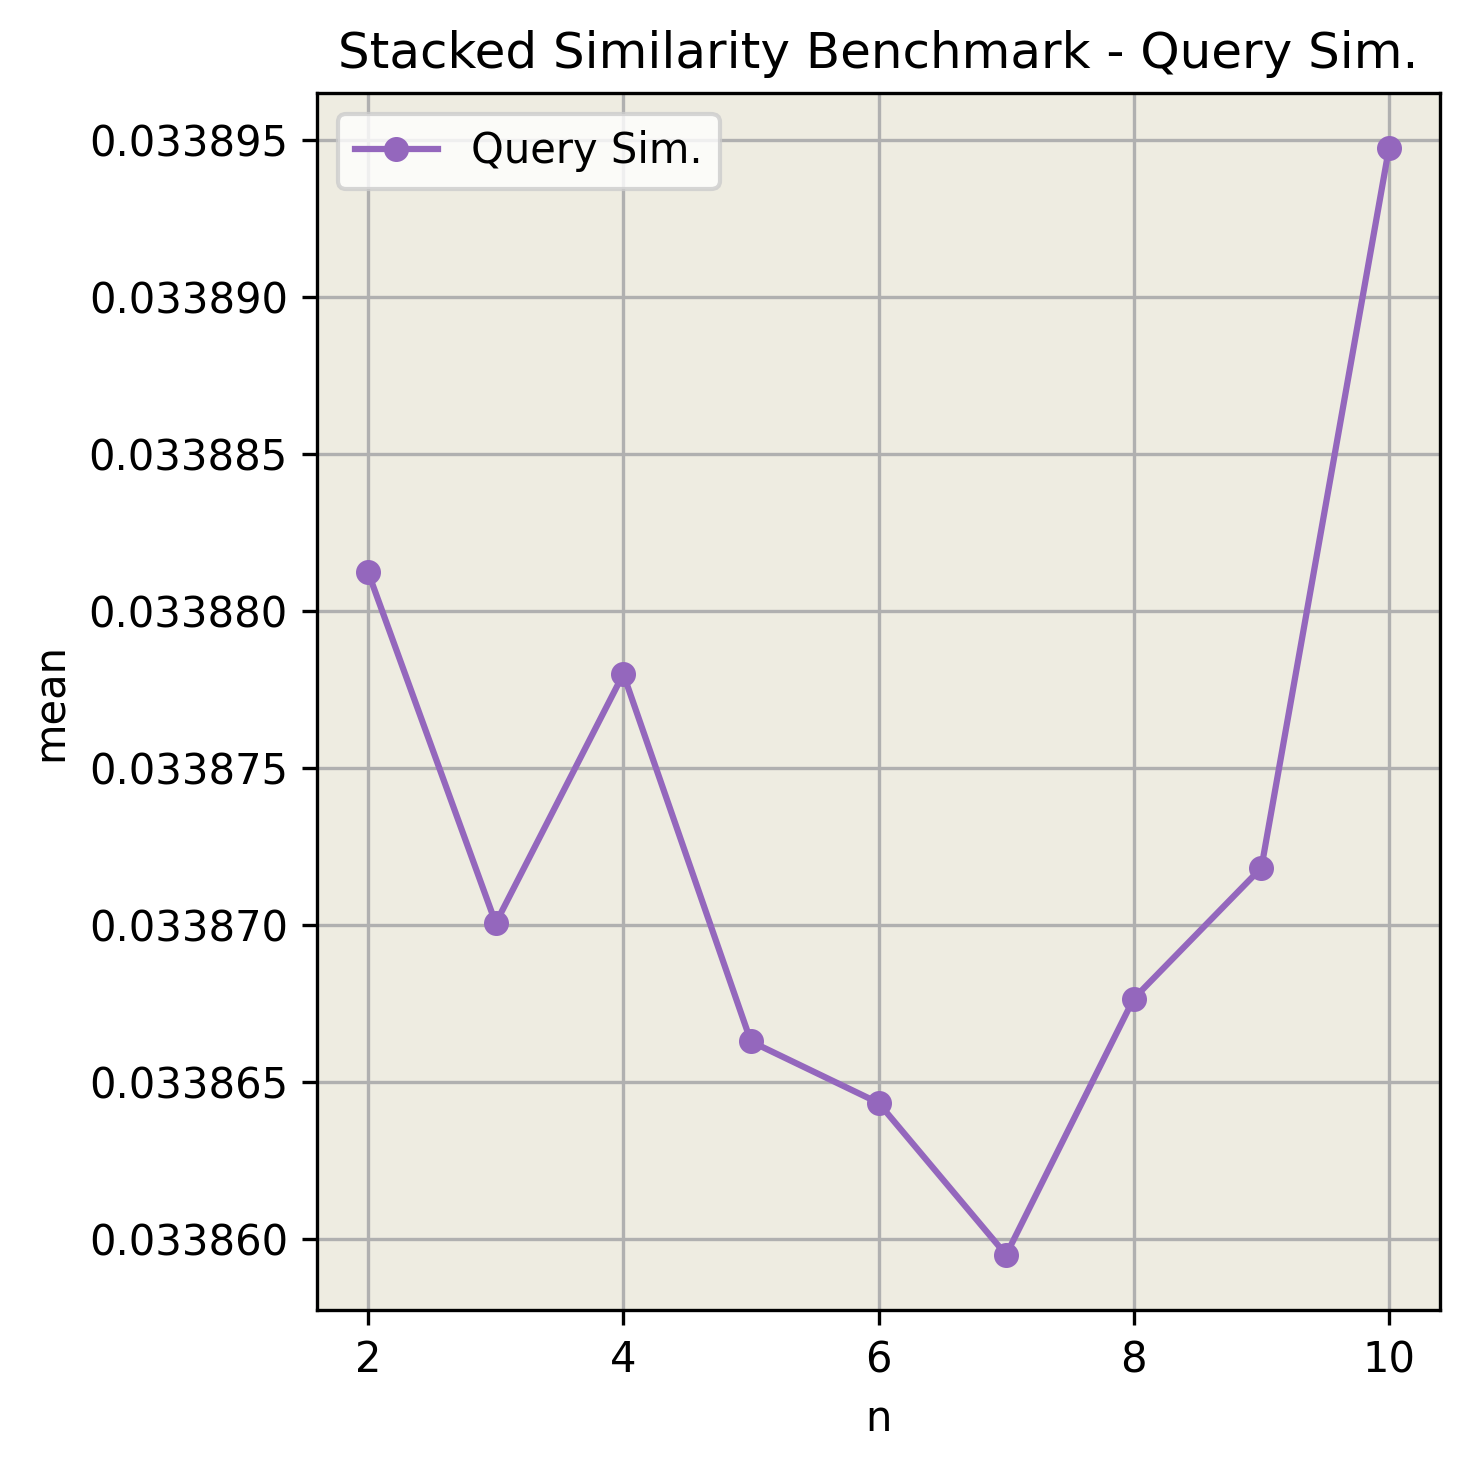

In [33]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)  # 2 rows, 4 columns for 7 plots + 1 empty

column = "Query Sim."
x = benchmark_df.index
y = benchmark_df[column]

# Plot lines with different markers
ax.plot(x, y, label=f"{column}", marker='o', markersize=5, color=colors[4])
ax.set_facecolor(background)

ax.set_xlabel("n")
ax.set_ylabel("mean")
ax.grid(True)
ax.set_title(f"Stacked Similarity Benchmark - {column}")
ax.legend()

# Hide the last empty subplot
#axes[7].set_visible(False)

plt.tight_layout()
plt.show()

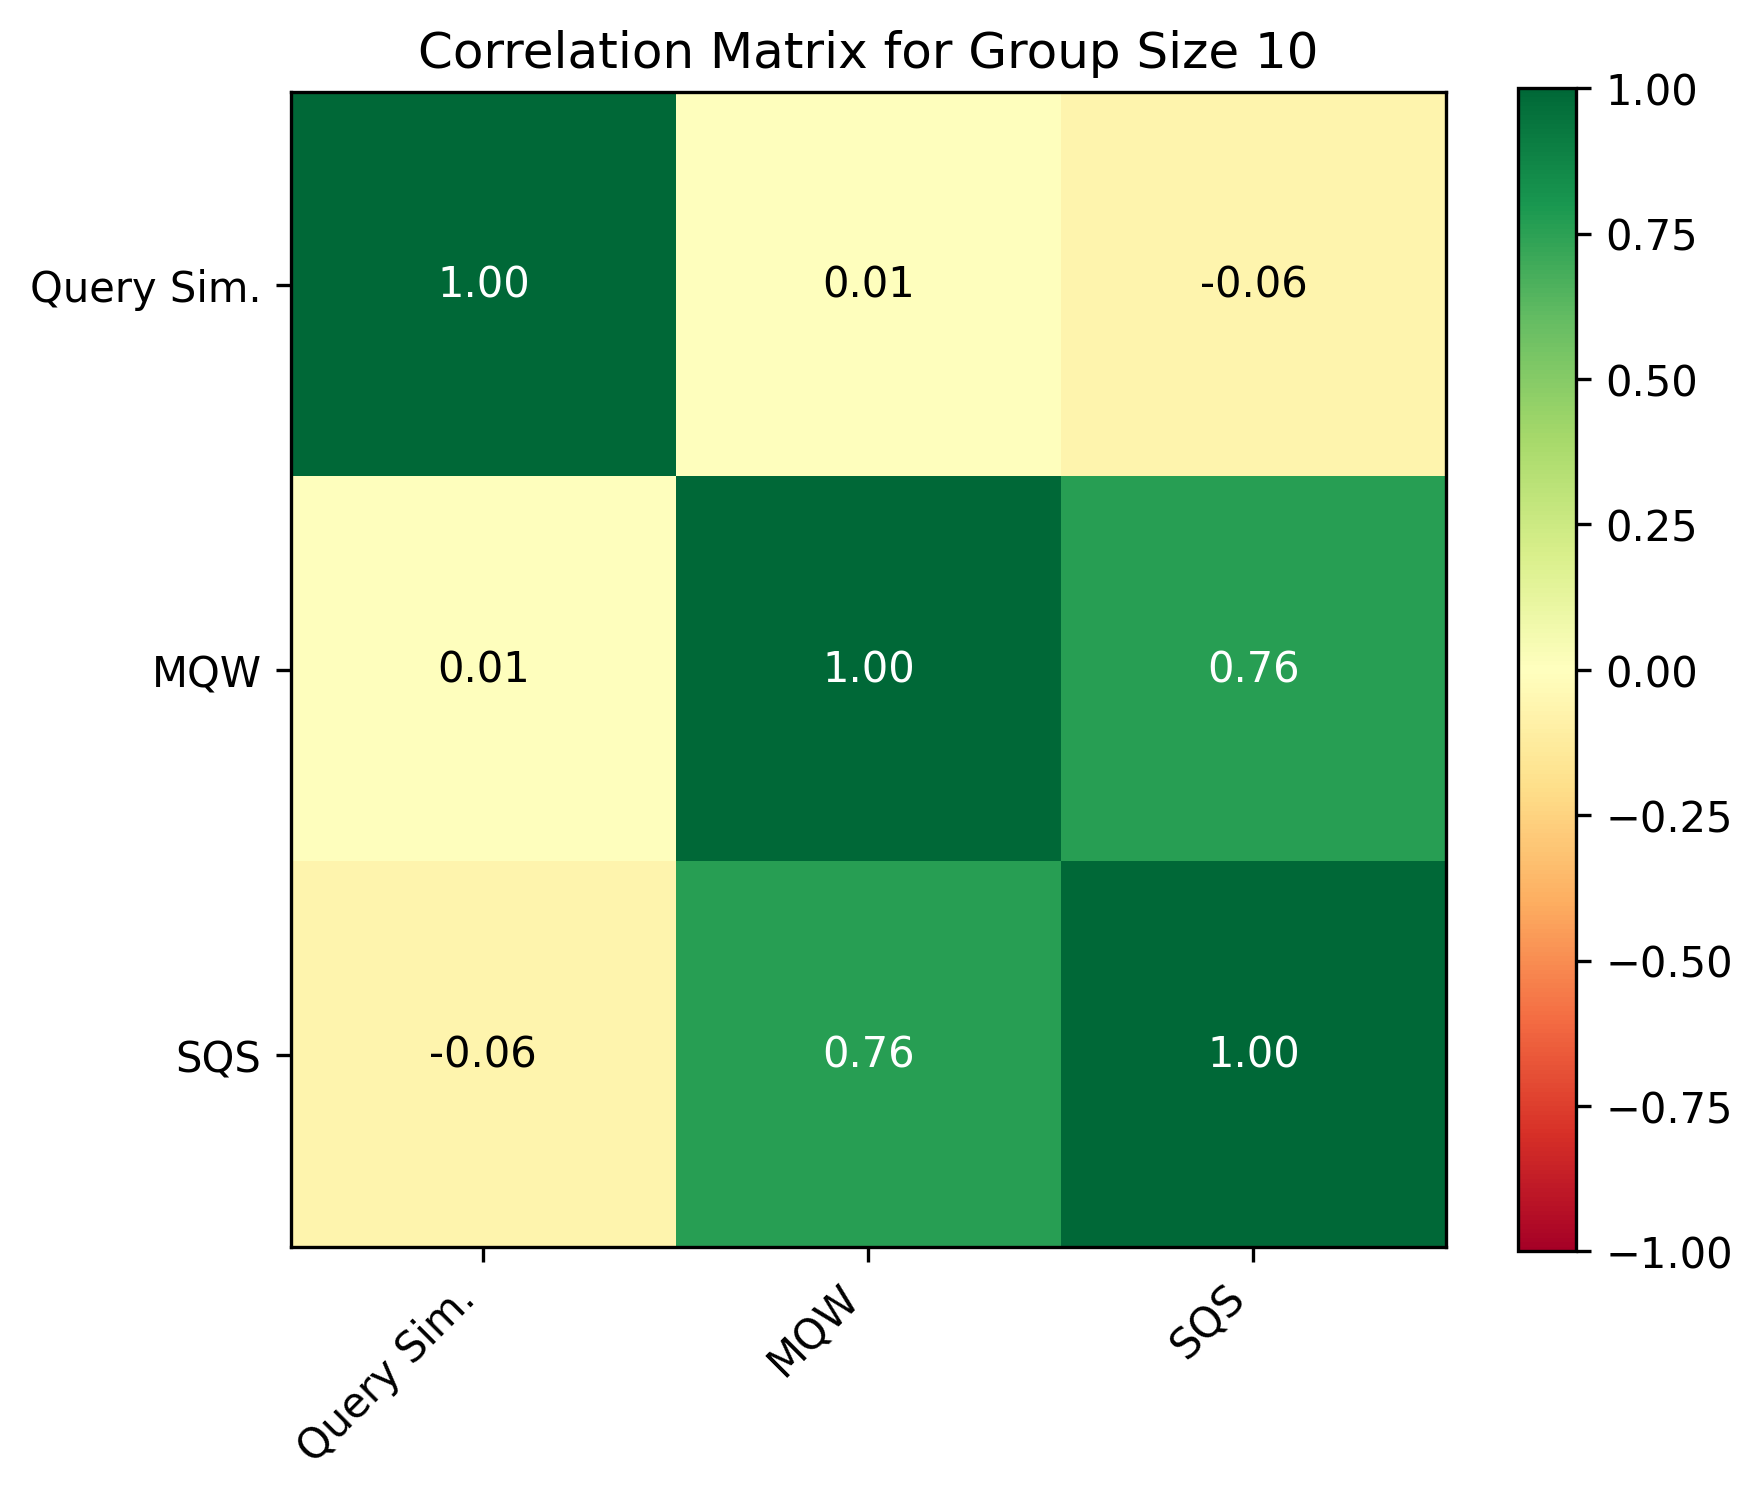

In [34]:
import matplotlib.pyplot as plt

df_id = 8

# Create correlation matrix heatmap without seaborn
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
corr_matrix = all_dfs[df_id][thesis_columns].corr()

# Create heatmap using matplotlib
im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='equal',vmin=-1, vmax=1)

# Add colorbar
plt.colorbar(im)

# Set ticks and labels
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.index)

# Add correlation values as text
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.5 else "white")

plt.title(f"Correlation Matrix for Group Size {df_id + 2}")
plt.tight_layout()
plt.show()

#### Alternative plot for 2 corr matrices

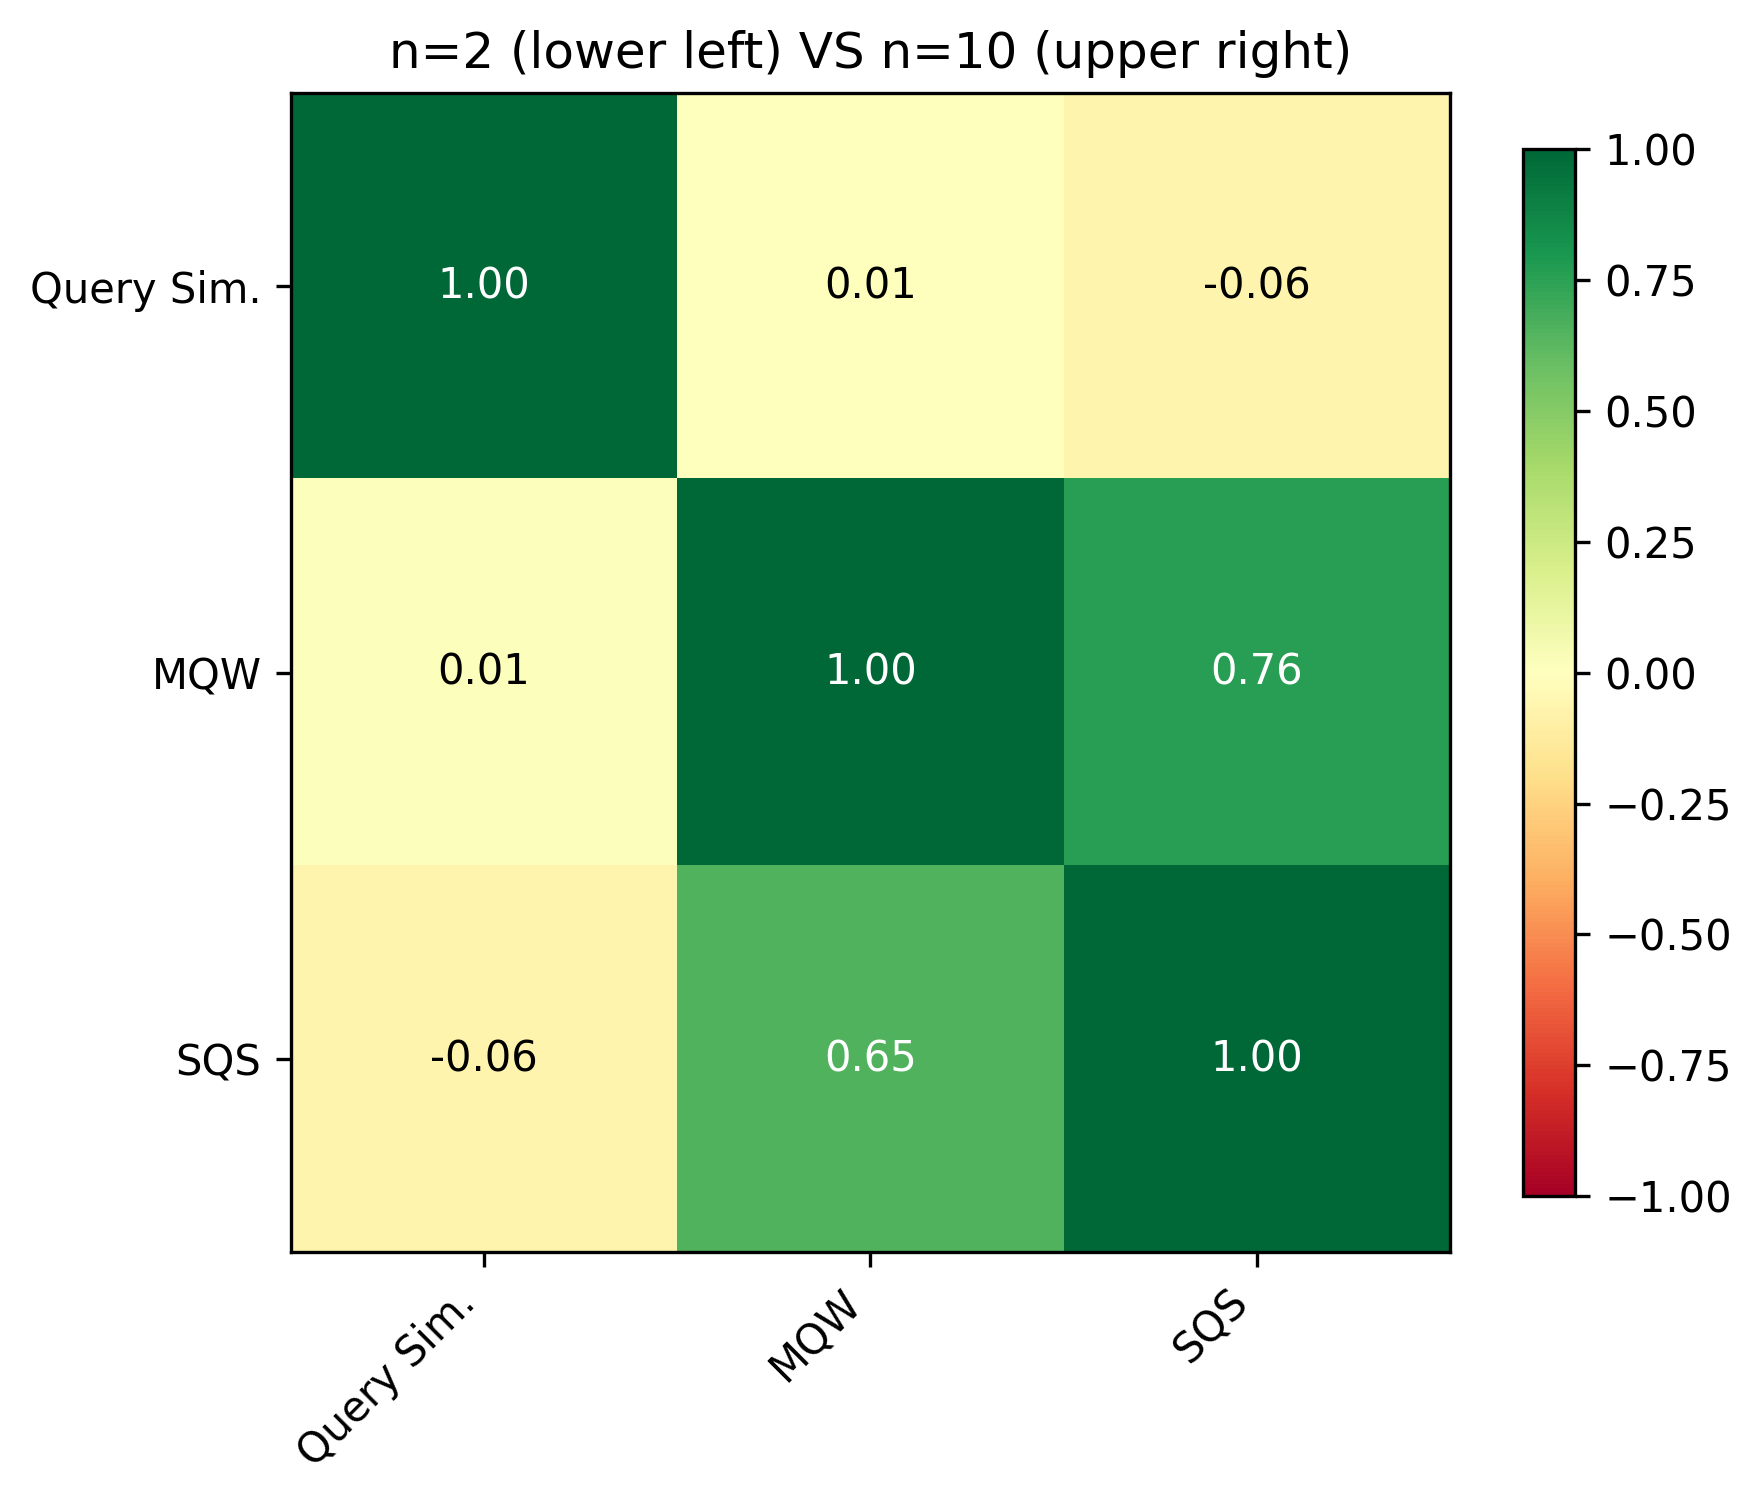

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with single subplot
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

# Calculate correlation matrices for both dataframes
corr_matrix_1 = all_dfs[n1-2][thesis_columns].corr()  # n=2 (lower left)
corr_matrix_2 = all_dfs[n2-2][thesis_columns].corr()  # n=10 (upper right)

# Create combined correlation matrix
combined_corr = corr_matrix_1.copy()

# Fill upper triangle with values from second matrix
for i in range(len(corr_matrix_1.index)):
    for j in range(len(corr_matrix_1.columns)):
        if i < j:  # Upper triangle
            combined_corr.iloc[i, j] = corr_matrix_2.iloc[i, j]

# Create heatmap
im = ax.imshow(combined_corr, cmap='RdYlGn', aspect='equal', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(range(len(combined_corr.columns)))
ax.set_yticks(range(len(combined_corr.index)))
ax.set_xticklabels(combined_corr.columns, rotation=45, ha='right')
ax.set_yticklabels(combined_corr.index)

# Add correlation values as text
for i in range(len(combined_corr.index)):
    for j in range(len(combined_corr.columns)):
        color = "white" if abs(combined_corr.iloc[i, j]) > 0.5 else "black"
        ax.text(j, i, f'{combined_corr.iloc[i, j]:.2f}',
                ha="center", va="center", color=color, fontsize=10)

# Add title and labels to indicate which triangle is which
ax.set_title(f"n={n1} (lower left) VS n={n2} (upper right)")

# Add colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.9)

plt.tight_layout()
plt.show()